In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
hawaii_meas = Base.classes.measurement
hawaii_stat = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(hawaii_meas.date).order_by(hawaii_meas.date.desc()).first()
recent_date

('2017-08-23',)

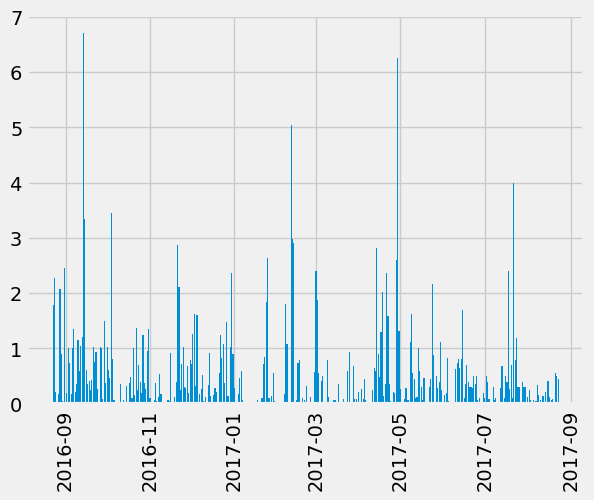

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime(2017, 8, 23) - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
prec_query = session.query(hawaii_meas.date, hawaii_meas.prcp).filter(hawaii_meas.date >= year_ago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prec_data_df = pd.read_sql(prec_query.statement, conn).dropna()
prec_data_df['date'] = prec_data_df['date'].astype('datetime64[ns]')

# Sort the dataframe by date
prec_data_df.sort_values(by='date', inplace=True)
prec_data_df_plot = prec_data_df.rename(columns={'prcp': 'Inches', 'date': 'Date'})

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prec_data_df_plot['Date'], prec_data_df_plot['Inches'])
plt.xticks(rotation='vertical')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_data_summary = prec_data_df['prcp'].describe().to_frame()
prec_data_summary

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(hawaii_meas.station))).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
distinct_stat = session.query(func.distinct(hawaii_meas.station), func.count(hawaii_meas.station)).\
    group_by(hawaii_meas.station).all()
distinct_stat

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Find the most active station by number or entries
most_active = ''
max_row = 0
for row in distinct_stat:
    if row[1] > max_row:
        max_row = row[1]
        most_active = row[0]

# Query for the min, max and avg temperature for the most active station
session.query(func.min(hawaii_meas.tobs), func.max(hawaii_meas.tobs), func.avg(hawaii_meas.tobs)).\
    filter(hawaii_meas.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

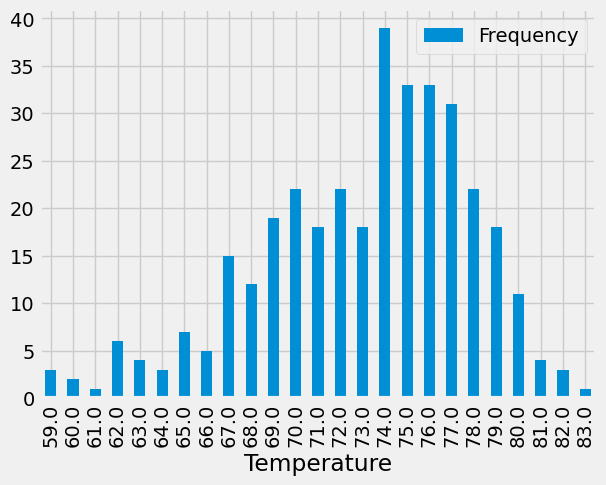

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_query = session.query(func.distinct(hawaii_meas.tobs), func.count(hawaii_meas.tobs)).group_by(hawaii_meas.tobs).filter(hawaii_meas.date >= year_ago).filter(hawaii_meas.station == most_active)

# Input the query result into a dataframe
temperature_plot_df = pd.read_sql(temperature_query.statement, conn).dropna().\
    rename(columns={'distinct_1': 'Temperature', 'count_1': 'Frequency'}).\
        set_index('Temperature')

temperature_plot_df.plot(kind='bar')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()